### Single model

In [7]:
# Scoring a model on neural data can be done in a single line using the `score_physiology` method.
# This call is agnostic of a specific model implementation, it will simply look up the model name 
# in `neurality.models.models` and use the implementation defined there (also see `examples/model-activations.ipynb`).
# By default, the pre-defined layers of a model will be used to retrieve the activations, 
# but you can also pass your own.
# Just like with the model implementations, the result of this method call will be cached 
# so that it only needs to be computed once.

from neurality import score_physiology

score = score_physiology(model='alexnet', neural_data='dicarlo.Majaj2015')
# the resulting score object now contains three fields: `center`, `error` and `values`.
# `values` are the raw scores across cross-validations and possibly neurons.
# The `center` and `error` then are computed over the raw `values` 
# and yield e.g. mean and standard deviation in a unified way so that plots across models can be compared.
# In the default case, there will be one score for each combination of layers and brain regions.
print("center\n", score.center)
# In the Brain-Score paper, we reported the maximum score across layers, i.e.:
print("\nlayer max\n", score.center.max('layer'))


center
 <xarray.DataAssembly (layer: 7, region: 2)>
array([[0.349049, 0.58051 ],
       [0.451555, 0.589968],
       [0.481759, 0.581112],
       [0.496249, 0.542313],
       [0.523878, 0.482408],
       [0.480724, 0.385361],
       [0.424411, 0.278921]])
Coordinates:
  * layer    (layer) object 'features.2' 'features.5' 'features.7' ...
  * region   (region) object 'IT' 'V4'

layer max
 <xarray.DataAssembly (region: 2)>
array([0.523878, 0.589968])
Coordinates:
  * region   (region) object 'IT' 'V4'


### Many models

Text(0,0.5,'Neural Predictivity')

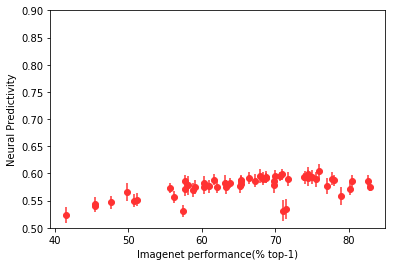

In [19]:
from collections import OrderedDict
%matplotlib inline

# The power of this framework partly stems from the ability to quickly score many models.
# In the following, we will reproduce Figure 2 from the paper for IT.
from matplotlib import pyplot
from neurality import score_physiology
from neurality.models import models_meta

models_performance = {row['model']: row['top1'] * 100 for _, row in models_meta.iterrows() if not row['model'].startswith('basenet')
                      # the TF Slim implementation of ResNets v1 is potentially erroneous, so we exclude them
                      and row['model'] not in ['resnet-50_v1', 'resnet-101_v1', 'resnet-101_v2', 'resnet-152_v1']}
model_it_score_means, model_it_score_errs = OrderedDict(), OrderedDict()
for model in models_performance:
    # score the model
    score = score_physiology(model=model, neural_data='dicarlo.Majaj2015')
    # ignore V4, only plot the IT score
    it_score = score.center.sel(region='IT')
    # use the best layer's score as the model's score
    max_score = it_score.max('layer')
    max_layer = it_score.where(it_score == max_score, drop=True)['layer']
    model_it_score_means[model] = max_score
    model_it_score_errs[model] = score.error.sel(region='IT', layer=max_layer)
# plot
x, y, err = list(models_performance.values()), list(model_it_score_means.values()), list(model_it_score_errs.values())
pyplot.scatter(x, y, color='#ff3232')
pyplot.errorbar(x, y, yerr=err, color='#ff3232', linestyle='None')
pyplot.ylim([.5, .9])
pyplot.xlabel('Imagenet performance(% top-1)')
pyplot.ylabel('Neural Predictivity')
